In [1]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import evofr as ef
import matplotlib.pyplot as plt


In [37]:
# Getting data for analysis from #ncov-escape
PANGO_VARIANT_SEQUENCE_COUNTS_URL = "https://raw.githubusercontent.com/blab/ncov-escape/master/mlr-fitness/data/pango_location-variant-sequence-counts.tsv"
PANGO_VARIANT_RELATIONSHIPS_URL = "https://raw.githubusercontent.com/blab/ncov-escape/master/mlr-fitness/data/pango_variant-relationships.tsv"

# Loading data into pandas
raw_seq = pd.read_csv(PANGO_VARIANT_SEQUENCE_COUNTS_URL, sep="\t")
raw_variant_parents = pd.read_csv(PANGO_VARIANT_RELATIONSHIPS_URL, sep="\t")

In [3]:
variant_freqs = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")
variant_freqs

In [9]:
# Defining model
mlr = ef.InnovationMLR(tau=4.2)

# Defining inference method
inference_method = ef.InferMAP(iters=50_000, lr=4e-3)

In [12]:
init_strat, posterior_map = ef.init_to_MAP(mlr, variant_freqs, iters=30_000, lr=1e-2)
inference_method = ef.InferNUTS(num_warmup=300, num_samples=200, init_strategy=init_strat)

In [13]:
# Fitting model
posterior = inference_method.fit(mlr, variant_freqs)
samples = posterior.samples

sample: 100%|███████████████████████████████████████████████████████████████████| 700/700 [02:39<00:00,  4.39it/s, 1023 steps of size 2.80e-03. acc. prob=0.91]


Text(0, 0.5, 'Growth advantage')

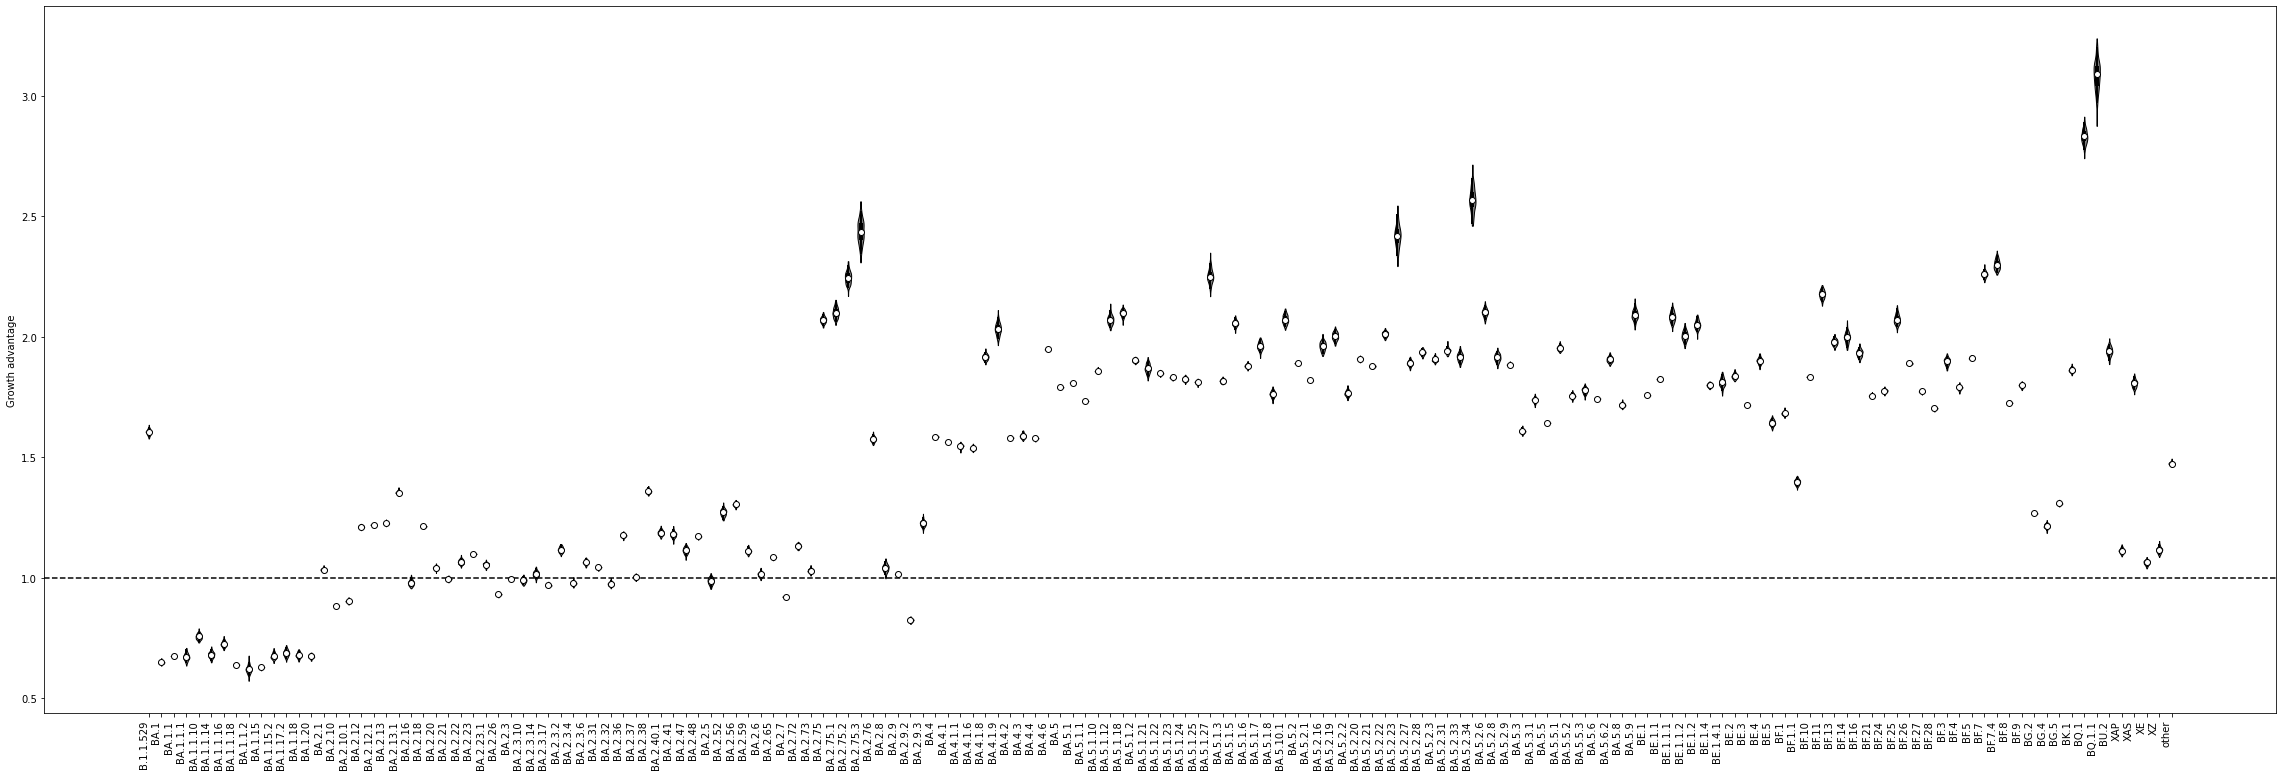

In [15]:
from evofr.plotting import plot_growth_advantage
fig = plt.figure(figsize=(40, 13))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

plot_growth_advantage(ax, samples, variant_freqs, [0.8], [0.4], ["grey"] * 165)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
ax.set_ylabel("Growth advantage")

In [42]:
ga_df = pd.DataFrame(ef.posterior.get_growth_advantage(samples, variant_freqs, [0.8], "USA", rel_to="BA.2"))
ga_df

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.6045661,1.6174452,1.5896364
1,USA,BA.1,0.6477896,0.65352035,0.6425958
2,USA,BA.1.1,0.6743903,0.6758931,0.6727836
3,USA,BA.1.1.1,0.67023134,0.688952,0.6525882
4,USA,BA.1.1.10,0.7554538,0.7704541,0.74129146
...,...,...,...,...,...
158,USA,XAP,1.1119165,1.1235231,1.0987287
159,USA,XAS,1.80654,1.8253838,1.7847298
160,USA,XE,1.0624967,1.0732713,1.0497441
161,USA,XZ,1.1153789,1.1291,1.098012


In [25]:
def plot_growth_advantage_delta(
    ax, samples, LD, ps, alphas, colors
):
    gad = jnp.array(jnp.exp(samples["delta"]))

    inds = jnp.arange(0, gad.shape[-1], 1)

    ax.axhline(y=1.0, color="k", linestyle="--")
    parts = ax.violinplot(
        gad.T, inds, showmeans=False, showmedians=False, showextrema=False
    )

    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor("black")
        pc.set_alpha(1)

    q1, med, q3 = jnp.percentile(gad, jnp.array([25, 50, 75]), axis=0)
    ax.scatter(inds, med, color="white", zorder=3, edgecolor="black")
    ax.vlines(inds, q1, q3, color="k", lw=4, zorder=2)

    q1, med, q3 = jnp.percentile(gad, jnp.array([2.5, 50, 97.5]), axis=0)
    ax.vlines(inds, q1, q3, color="k", lw=2, zorder=1)

    ax.set_xticks(inds)
    ax.set_xticklabels(LD.var_names)

Text(0, 0.5, 'Growth advantage change')

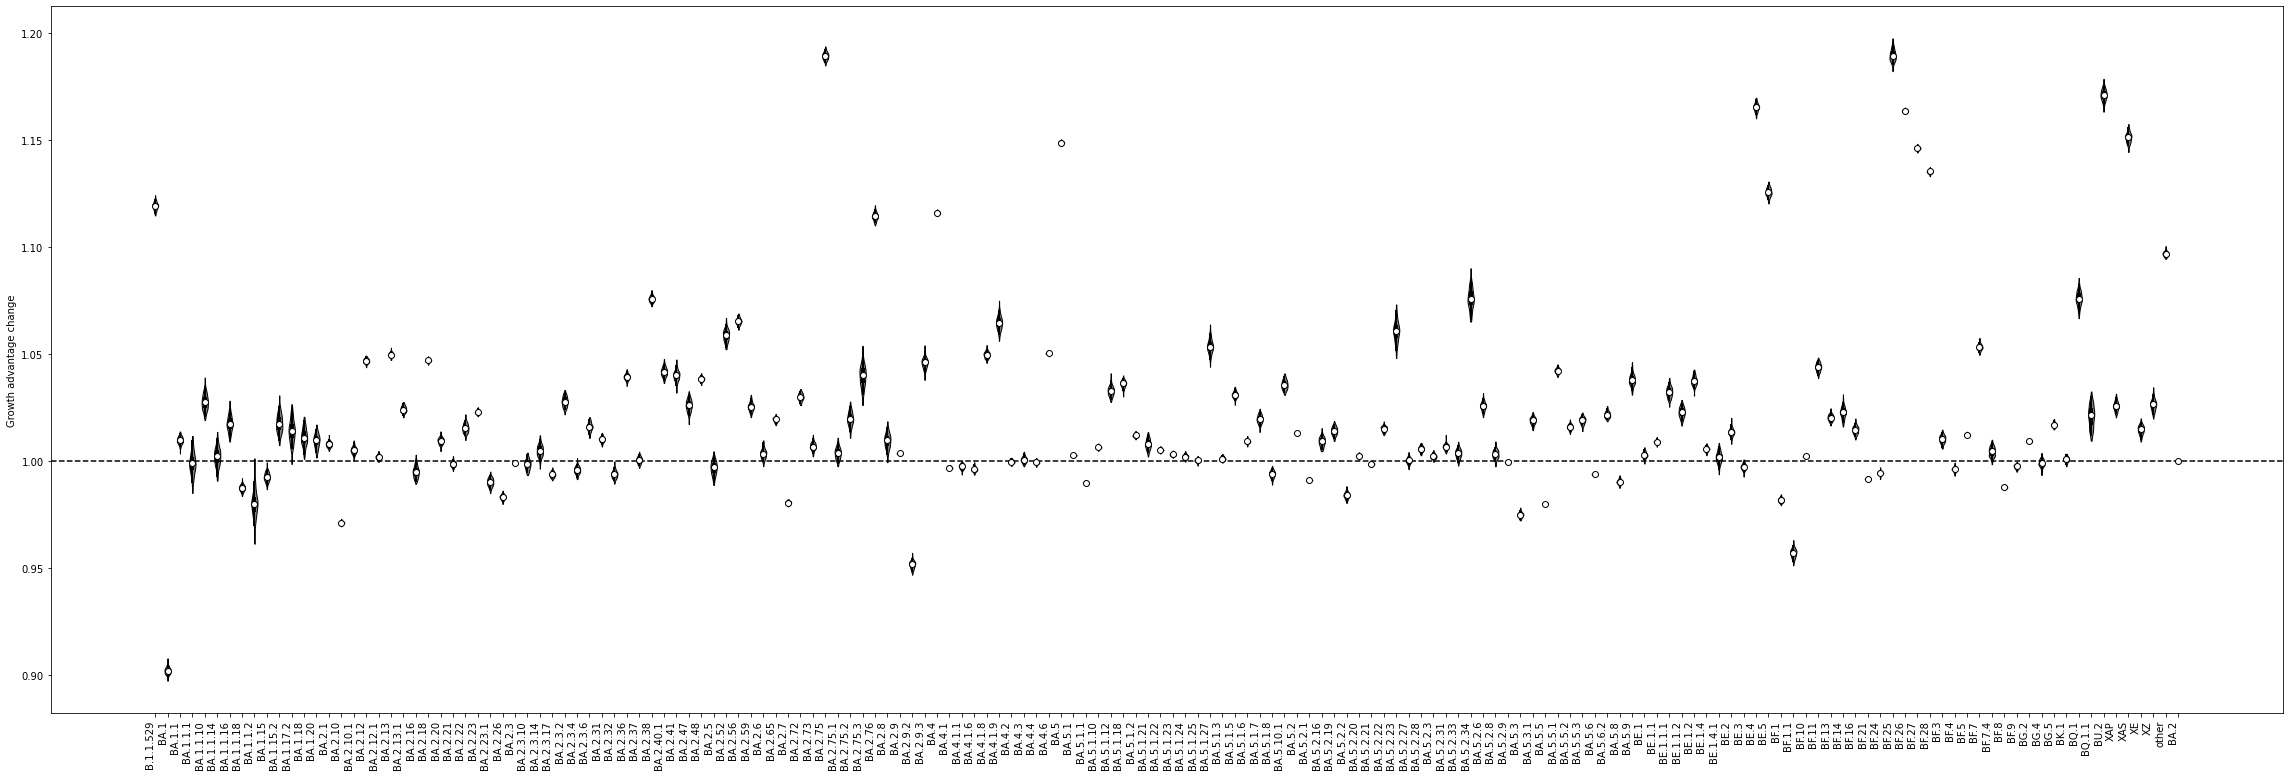

In [27]:
from evofr.plotting import plot_growth_advantage
fig = plt.figure(figsize=(40, 13))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

plot_growth_advantage_delta(ax, samples, variant_freqs, [0.8], [0.4], ["grey"] * 164)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
ax.set_ylabel("Growth advantage change")

In [35]:
def get_growth_advantage_delta(samples, data, ps, name, rel_to="other"):
    # Unpack variant info
    var_names = data.var_names

    # Get posterior samples
    ga = jnp.array(jnp.exp(samples["delta"]))
    N_variant = ga.shape[-1]

    # Loop over ga and make relative rel_to
    for i, s in enumerate(var_names):
        if s == rel_to:
            ga = jnp.divide(ga, ga[:, i][:, None])

    #ga = jnp.divide(ga, ga[:, var_names.index(rel_to)][:, None])

    # Compute medians and quantiles
    meds = jnp.median(ga, axis=0)
    gas = []
    for i, p in enumerate(ps):
        up = 0.5 + p / 2
        lp = 0.5 - p / 2
        gas.append(jnp.quantile(ga, jnp.array([lp, up]), axis=0).T)

    # Make empty dictionary
    v_dict = dict()
    pv_dict["location"] = []
    v_dict["variant"] = []
    v_dict["median_ga_delta"] = []

    for p in ps:
        v_dict[f"ga_delta_upper_{round(p * 100)}"] = []
        v_dict[f"ga_delta_lower_{round(p * 100)}"] = []

    for variant in range(N_variant):
        if var_names[variant] != rel_to:
            v_dict["location"].append(name)
            v_dict["variant"].append(var_names[variant])
            v_dict["median_ga_delta"].append(meds[variant])
            for i, p in enumerate(ps):
                v_dict[f"ga_delta_upper_{round(p * 100)}"].append(gas[i][variant, 1])
                v_dict[f"ga_delta_lower_{round(p * 100)}"].append(gas[i][variant, 0])

    return v_dict

In [36]:
ga_delta_df = pd.DataFrame(get_growth_advantage_delta(samples, variant_freqs, [0.8], "USA", rel_to="BA.2"))

,location,variant,median_ga_delta,ga_delta_upper_80,ga_delta_lower_80
0,USA,B.1.1.529,1.1191664,1.1212988,1.1166782
1,USA,BA.1,0.9017856,0.9036787,0.9000589
2,USA,BA.1.1,1.0094644,1.011718,1.007447
3,USA,BA.1.1.1,0.9986733,1.0053251,0.99242455
4,USA,BA.1.1.10,1.0273421,1.0320786,1.0227413
...,...,...,...,...,...
158,USA,XAP,1.0255802,1.0281188,1.0226707
159,USA,XAS,1.151209,1.1540568,1.1478845
160,USA,XE,1.0145384,1.0169785,1.0116258
161,USA,XZ,1.0263395,1.0293317,1.0225118
